In [197]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

# charts
import seaborn as sns
import matplotlib.pyplot as plt

# encoding (for categorical features)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import model_selection

from scipy import sparse

import xgboost as xgb

from sklearn.metrics import log_loss

['train.json', 'images_sample', 'sample_submission.csv', 'Kaggle-renthop.torrent', 'test.json']


In [198]:
# Column consts
COL_BATHROOMS      = "bathrooms"
COL_BEDROOMS       = "bedrooms"
COL_LATITUDE       = "latitude"
COL_LONGITUDE      = "longitude"
COL_PRICE          = "price"
COL_PHOTOS         = "photos"
COL_FEATURES       = "features"
COL_DESCRIPTION    = "description"
COL_NUM_PHOTOS     = "num_photos"
COL_NUM_FEATURES   = "num_features"
COL_NUM_DESC_WORDS = "num_description_words"
COL_CREATED        = "created"
COL_CREATED_YEAR   = "created_year"
COL_CREATED_MONTH  = "created_month"
COL_CREATED_DAY    = "created_day"
COL_LISTING_ID     = "listing_id"
COL_CREATED_HOUR   = "created_hour"
COL_DISPLAY_ADDR   = "display_address"
COL_MANAGER_ID     = "manager_id"
COL_BUILDING_ID    = "building_id"
COL_STREET_ADDR    = "street_address"
COL_TARGET         = "interest_level"

In [199]:
train_df = pd.read_json("../input/train.json")
test_df = pd.read_json("../input/test.json")
# data desciption
#print("Size: ", train_df.shape)
#print("Colums: ", train_df.columns)
#print("Types: \n", train_df.dtypes)
#print("Amoun of empty fields: \n", train_df.isnull().sum())
#print(train_df.describe())
#print(train_df[train_df['interest_level'] == "low"].value_counts())

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


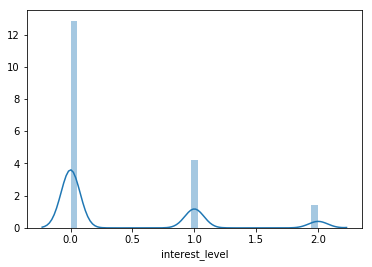

In [200]:
# Для дальнейший работы и анализа данных заменим все необходимые нечисловые колонки на числовые 

# Для начала заменим уровень интереса на 0,1,2 для low, medium, high соответсвенно и построим их распределение
train_df[COL_TARGET] = train_df[COL_TARGET].map({'high': 2, 'medium': 1, 'low': 0})
sns.distplot(train_df[COL_TARGET])
# На данной диаграмме видно, большинство предложений вызывают слабый интерес у пользователя

# Заменим строковые фичи на числовые
features_to_use  = [COL_BATHROOMS, COL_BEDROOMS, COL_LATITUDE, COL_LONGITUDE, COL_PRICE]

train_df[COL_NUM_PHOTOS] = train_df[COL_PHOTOS].apply(len)
test_df[COL_NUM_PHOTOS]  = test_df[COL_PHOTOS].apply(len)

train_df[COL_NUM_FEATURES] = train_df[COL_FEATURES].apply(len)
test_df[COL_NUM_FEATURES]  = test_df[COL_FEATURES].apply(len)

train_df[COL_NUM_DESC_WORDS] = train_df[COL_DESCRIPTION].apply(lambda x: len(x.split(" ")))
test_df[COL_NUM_DESC_WORDS]  = test_df[COL_DESCRIPTION].apply(lambda x: len(x.split(" ")))

train_df[COL_CREATED] = pd.to_datetime(train_df[COL_CREATED])
test_df[COL_CREATED]  = pd.to_datetime(test_df[COL_CREATED])

train_df[COL_CREATED_YEAR]  = train_df[COL_CREATED].dt.year
test_df[COL_CREATED_YEAR]   = test_df[COL_CREATED].dt.year
train_df[COL_CREATED_MONTH] = train_df[COL_CREATED].dt.month
test_df[COL_CREATED_MONTH]  = test_df[COL_CREATED].dt.month
train_df[COL_CREATED_DAY]   = train_df[COL_CREATED].dt.day
test_df[COL_CREATED_DAY]    = test_df[COL_CREATED].dt.day
train_df[COL_CREATED_HOUR]  = train_df[COL_CREATED].dt.hour
test_df[COL_CREATED_HOUR]   = test_df[COL_CREATED].dt.hour

features_to_use.extend([COL_NUM_PHOTOS, COL_NUM_FEATURES, COL_NUM_DESC_WORDS, COL_CREATED_YEAR, COL_CREATED_MONTH, COL_CREATED_DAY, COL_LISTING_ID, COL_CREATED_HOUR])

# Данный код я взял из уже готовых решений
# Считаем кол-во фотографий, но в реальной жизни влияет еще и качество фотографий (первое впечатление от обложки)
# Описание, опять же считаем кол-во символов, в реальности влияет еще и качество текста, что тоже затруднительно проанализировать

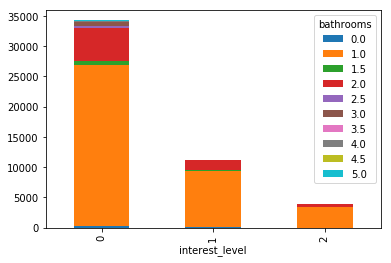

In [201]:
# Построим таблицу сопряженности для выявление связи между кол-вом ванных комнат и уровнем интереса пользователя
ct = pd.crosstab(train_df[COL_TARGET], train_df[COL_BATHROOMS])
# Возьмем основную часть, отбросив экзотичные варианты с 10 ваннами :)
ct.iloc[:,0:10].plot.bar(stacked=True)
# По графику видно, что распределение относительно равномерно, 
# и большую долю занимают квартиры с 1,2 ваннами,\
# что довольно предсказуемо - у квартир в преимуществе стандартная проектировка

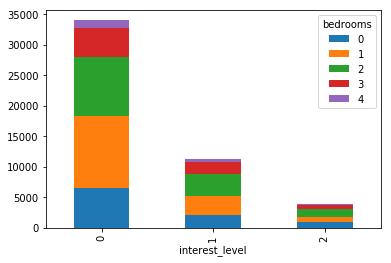

In [202]:
# Пременим те же инструменты для выявляния связи спальных и уровнем интереса
ct = pd.crosstab(train_df[COL_TARGET], train_df[COL_BEDROOMS])
ct.iloc[:,0:5].plot.bar(stacked=True)
# Опять же распределение равномерно, и нельзя сказать, что какое то количество сильно влияет на интерес

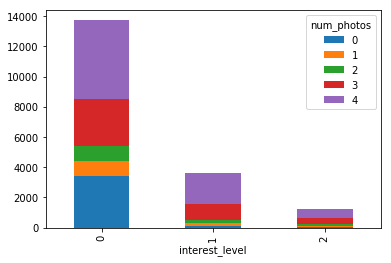

In [203]:
# Рассмотрим как влияет количество фотографий
ct = pd.crosstab(train_df[COL_TARGET], train_df[COL_NUM_PHOTOS])
ct.iloc[:,0:5].plot.bar(stacked=True)
#  можно сделать вывод, что при их остутсвии интерес к просмотру апартаментов явно падает, то есть нужна хотя бы одна заглавная фоторгафия 

In [204]:
# Необходимо привести категориальные фичи к числовому типу -> существуют два основных способа: Label & One-Hot encoding
# Я возьму Label Encoding так как это более компактное решение, потому что каждое описание по своему уникально (хотя бы знаками препинания),
# остальные фичи хоть и меньше 
# а также в статьях советуют использовать такой подход при работе с алгоритмами построенных на деревьх решений,
# в моем случае -  модели XGBoost, CatBoost, LightGBM 
categorical = [COL_DISPLAY_ADDR, COL_MANAGER_ID, COL_BUILDING_ID, COL_STREET_ADDR]
for categoty in categorical:
        if train_df[categoty].dtype=='object':
            label_encoder = LabelEncoder()
            # найдем все уникальные значения для обучения и проверки 
            label_encoder.fit(list(train_df[categoty].values) + list(test_df[categoty].values))
            # преобразуем в числа 
            train_df[categoty] = label_encoder.transform(list(train_df[categoty].values))
            test_df[categoty] = label_encoder.transform(list(test_df[categoty].values))
            features_to_use.append(categoty)


In [205]:
train_X = train_df[features_to_use]
test_X = test_df[features_to_use]
train_y = np.array(train_df['interest_level'])
#print(train_X.head(), end="\n--------------------------------------------------------------------------------------------\n")
#print(test_X.head(),  end="\n--------------------------------------------------------------------------------------------\n")

In [206]:
# Воспользуемся кросс валидацией для оценки модели 
# Разобьем обучающую выбору на 5 фолдов и перемешаем данные
# Это позволит использовать ограниченную выборку для оценки ожидаемого поведения модели 
# на данных, которые не использовались во время обучения модели.
cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for train_index, test_index in kf.split(train_X):
        X_train, X_test = train_X.iloc[train_index,:], train_X.iloc[test_index, :]
        y_train, y_test = train_y[train_index], train_y[test_index]
   
        param = {}
        param['objective'] = 'multi:softprob'
        param['eta'] = 0.1
        param['max_depth'] = 6
        param['silent'] = 1
        param['num_class'] = 3
        param['eval_metric'] = "mlogloss"
        param['min_child_weight'] = 1
        param['subsample'] = 0.7
        param['colsample_bytree'] = 0.7
        param['seed'] = 0
        num_rounds = 1000
        plst = list(param.items())

        xgtrain = xgb.DMatrix(X_train, label=y_train)
        xgtest = xgb.DMatrix(X_test, label=y_test)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
        pred_test_y = model.predict(xgtest)

        log_loss(val_y, pred_test_y)
        print(log_loss)
        
        break

[0]	train-mlogloss:1.04288	test-mlogloss:1.04363
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:0.993762	test-mlogloss:0.995287
[2]	train-mlogloss:0.949719	test-mlogloss:0.952094
[3]	train-mlogloss:0.912866	test-mlogloss:0.915948
[4]	train-mlogloss:0.879688	test-mlogloss:0.883577
[5]	train-mlogloss:0.851342	test-mlogloss:0.856123
[6]	train-mlogloss:0.825756	test-mlogloss:0.831279
[7]	train-mlogloss:0.804222	test-mlogloss:0.810491
[8]	train-mlogloss:0.786097	test-mlogloss:0.792975
[9]	train-mlogloss:0.767251	test-mlogloss:0.774803
[10]	train-mlogloss:0.752729	test-mlogloss:0.760842
[11]	train-mlogloss:0.739038	test-mlogloss:0.747674
[12]	train-mlogloss:0.727864	test-mlogloss:0.736953
[13]	train-mlogloss:0.716431	test-mlogloss:0.726211
[14]	train-mlogloss:0.706672	test-mlogloss:0.716982
[15]	train-mlogloss:0.696371	test-mlogloss:0.707361
[16]	train-mlogloss:0.686348	

[155]	train-mlogloss:0.468981	test-mlogloss:0.570598
[156]	train-mlogloss:0.468427	test-mlogloss:0.570522
[157]	train-mlogloss:0.467904	test-mlogloss:0.570451
[158]	train-mlogloss:0.467464	test-mlogloss:0.570419
[159]	train-mlogloss:0.466697	test-mlogloss:0.570288
[160]	train-mlogloss:0.466047	test-mlogloss:0.570237
[161]	train-mlogloss:0.465312	test-mlogloss:0.570111
[162]	train-mlogloss:0.464637	test-mlogloss:0.570063
[163]	train-mlogloss:0.464133	test-mlogloss:0.569897
[164]	train-mlogloss:0.463447	test-mlogloss:0.569689
[165]	train-mlogloss:0.462871	test-mlogloss:0.569652
[166]	train-mlogloss:0.46214	test-mlogloss:0.569472
[167]	train-mlogloss:0.461308	test-mlogloss:0.569282
[168]	train-mlogloss:0.46057	test-mlogloss:0.569124
[169]	train-mlogloss:0.460008	test-mlogloss:0.56906
[170]	train-mlogloss:0.459379	test-mlogloss:0.568989
[171]	train-mlogloss:0.458842	test-mlogloss:0.568951
[172]	train-mlogloss:0.458422	test-mlogloss:0.568778
[173]	train-mlogloss:0.457778	test-mlogloss:0.568

In [208]:
param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.1
param['max_depth'] = 6
param['silent'] = 1
param['num_class'] = 3
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 1
param['subsample'] = 0.7
param['colsample_bytree'] = 0.7
param['seed'] = 0
num_rounds = 400
plst = list(param.items())

xgtrain = xgb.DMatrix(train_X, label=train_y)
xgtest = xgb.DMatrix(test_X)
model = xgb.train(plst, xgtrain, num_rounds)
pred_test_y = model.predict(xgtest)
    
out_df = pd.DataFrame(pred_test_y)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test_df.listing_id.values
out_df.to_csv("result.csv", index=False)
